In [37]:
import operator
from typing import List
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,END
from IPython.display import Image, display
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.output_parsers import PydanticOutputParser
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
import operator
import asyncio
import json
import uuid
import websockets
from typing import Dict, List, Any, Optional

## tools related libraries 
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.prebuilt import ToolNode
from langchain.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState,StateGraph, END, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display
import yfinance as yf

In [38]:
from langchain_openai import ChatOpenAI
llm=ChatOpenAI(model='gpt-3.5-turbo')

In [39]:
!pip install nest-asyncio

C:\Users\samra\AppData\Roaming\Python\Python311\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedWriter name=3>
  return process_handler(cmd, _system_body)
C:\Users\samra\AppData\Roaming\Python\Python311\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=4>
  return process_handler(cmd, _system_body)
C:\Users\samra\AppData\Roaming\Python\Python311\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=5>
  return process_handler(cmd, _system_body)


In [40]:
from langchain.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """
    Multiply two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The product of a and b.
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """
    Add two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The sum of a and b.
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """
    Divide two integers.

    Args:
        a (int): The numerator.
        b (int): The denominator (must not be 0).

    Returns:
        float: The result of division.
    """
    if b == 0:
        raise ValueError("Denominator cannot be zero.")
    return a / b

# First install: pip install nest-asyncio

import nest_asyncio
nest_asyncio.apply()

import concurrent.futures

@tool
def get_alerts(state: str) -> str:
    """
    Get weather alerts for a US state from a local MCP weather server.
    
    Args:
        state (str): Two-letter US state code (e.g., 'AZ', 'CA', 'NY')
    
    Returns:
        str: Weather alerts information for the state
    """
    
    return("weather is 27 degrees celsius")

@tool
def get_stock_price(ticker:str)->str:
    """
    Fetches the previous closing price of a given stock ticker from Yahoo Finance.

    Args:
        ticker (str): The stock ticker symbol (e.g., 'AAPL', 'TSLA', 'NIFTY.BO').

    Returns:
        str: A message with the stock's previous closing price.
    """
    try:
        stock = yf.Ticker(ticker)
        price = stock.info.get('previousClose')
        if price is None:
            return f"Could not fetch price for ticker '{ticker}'."
        return f"The last closing price of {ticker.upper()} was ${price:.2f}."
    except Exception as e:
        return f"An error occurred while fetching stock data: {str(e)}"

search=DuckDuckGoSearchRun()

tools=[multiply, add, divide, search, get_alerts,get_stock_price]
llm_with_tools=llm.bind_tools(tools)

In [41]:
SYSTEM_PROMPT="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs."
def function_1(state:MessagesState):
    user_question=state["messages"]
    input_question = [SYSTEM_PROMPT]+user_question
    response = llm_with_tools.invoke(input_question)
    return {
        "messages":[response]
    }

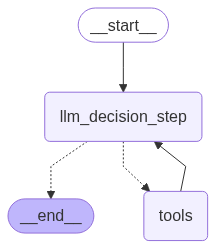

In [42]:
workflow=StateGraph(MessagesState)
workflow.add_node("llm_decision_step",function_1)
workflow.add_node("tools",ToolNode(tools))
workflow.add_edge(START,"llm_decision_step")
workflow.add_conditional_edges(
    "llm_decision_step",
    tools_condition,
)
workflow.add_edge("tools","llm_decision_step")
react_graph = workflow.compile()
display(Image(react_graph.get_graph().draw_mermaid_png()))


In [43]:
# messages = [HumanMessage(content="add 1000 in the current stock price of Apple.")]
# messages = react_graph.invoke({"messages": messages})
# for m in messages['messages']:
#     m.pretty_print()

In [44]:
# messages = [HumanMessage(content="can you give me 2 times of current stock price of Apple with the latest news of the Apple.")]
# messages = react_graph.invoke({"messages": messages})
# for m in messages['messages']:
#     m.pretty_print()

In [45]:
messages = [HumanMessage(content="what is the weather alert in AZ?")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the weather alert in AZ?
================================== Ai Message ==================================
Tool Calls:
  get_alerts (call_ZU1VYgrfRKHWsqrJhjoK1LxO)
 Call ID: call_ZU1VYgrfRKHWsqrJhjoK1LxO
  Args:
    state: AZ
================================= Tool Message =================================
Name: get_alerts

weather is 27 degrees celsius
================================== Ai Message ==================================

The weather alert in Arizona is 27 degrees Celsius.
